In [4]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv(
  "mnist_train_small.csv",
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
1170,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8549,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2718,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2195,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
mnist_dataframe.loc[:, 72:74]

,72,73,74
1170,0,0,0
468,0,0,0
8549,0,0,0
2718,0,0,0
2195,0,0,0
...,...,...,...
4184,0,0,0
4901,0,0,0
2027,0,0,0
743,0,0,0


# 有意思的函数

- all(some_set) 意思是“是不是完全是真”。即集合中所有成员都是真的情况下才返回真，只要有一个不是真的就返回伪。
- any(some_set) 意思是“有没有真”。即集合中只要有真值存在就返回真。

In [6]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255

  return labels, features

In [7]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


In [8]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0


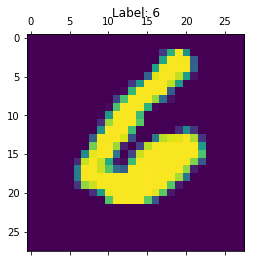

In [9]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

In [10]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  # There are 784 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [11]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [12]:
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [13]:
def train_dnn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    model_dir):
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: An `int`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `LinearClassifier` object.
  """

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create a LinearClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(),
      hidden_units=hidden_units,
      n_classes=10,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1),
      model_dir=model_dir
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 0.48
  period 01 : 0.35
  period 02 : 0.37
  period 03 : 0.29
  period 04 : 0.28
  period 05 : 0.28
  period 06 : 0.28
  period 07 : 0.26
  period 08 : 0.26
  period 09 : 0.26
Model training finished.
Final accuracy (on validation data): 0.99


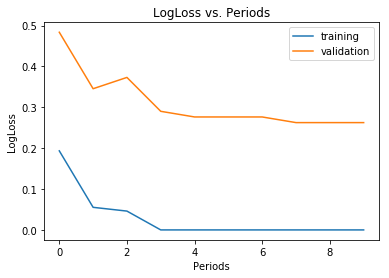

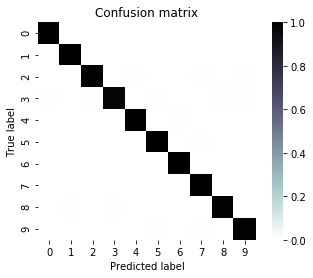

In [14]:
dnn_classifier = train_dnn_classification_model(
             learning_rate=0.05,
             steps=2000,
             batch_size=100, hidden_units = [128, 128, 128],
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets, model_dir='models/mnist.ckpt')

In [15]:
mnist_test_dataframe = pd.read_csv(
  "mnist_test.csv",
  sep=",",
  header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)

predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = dnn_classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

Accuracy on test data: 0.97


In [16]:
single_target = test_targets.head(1)
single_example = test_examples.head(1)
print(single_target)
print(single_example)
single_test_input_fn = create_predict_input_fn(single_example, single_target, batch_size=1)
single_prediction = dnn_classifier.predict(input_fn=single_test_input_fn)
for item in single_prediction:
    print(item['class_ids'][0])

0    7
Name: 0, dtype: int64
   1    2    3    4    5    6    7    8    9    10  ...   775  776  777  778  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   779  780  781  782  783  784  
0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 784 columns]
7


In [17]:
INPUT_FEATURE = 'pixels'
def serving_input_receiver_fn():
    """
    This is used to define inputs to serve the model.
    :return: ServingInputReciever
    """
    reciever_tensors = {
        # The size of input image is flexible.
        INPUT_FEATURE: tf.placeholder(tf.float32, [None, None, None, 1]),
    }

    # Convert give inputs to adjust to the model.
    features = {
        # Resize given images.
        INPUT_FEATURE: tf.image.resize_images(reciever_tensors[INPUT_FEATURE], [28, 28]),
    }
    return tf.estimator.export.ServingInputReceiver(receiver_tensors=reciever_tensors,
                                                    features=features)

# Save the model
dnn_classifier.export_savedmodel("models/mnist.pb",serving_input_receiver_fn=serving_input_receiver_fn)

b'models/mnist.pb/1530283172'

In [22]:
from tensorflow_serving.apis import classification_pb2
from tensorflow_serving.apis import regression_pb2
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2
from grpc.beta import implementations

host = "127.0.0.1"
port = 9000
channel = implementations.insecure_channel(host, int(port))
stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

request = classification_pb2.ClassificationRequest()
example = request.input.example_list.examples.add()
example.features.feature[INPUT_FEATURE] = single_example

result = stub.Classify(request, 10.0)  # 10 secs timeout

ModuleNotFoundError: No module named 'tensorflow_serving'